# Week 3: Classification

In this section we will apply what we have learned about the logistic regression model to fit a model and make predictions. We will be using the `penguins` dataset from `seaborn` and try to predict where or not a penguin is of Adelie species.

We will build a Logistic Regression model from scratch.


In [87]:
# Code for Week 5
import pandas as pd
import numpy as np
import seaborn as sns

# Import penguins
penguins = (sns.load_dataset("penguins")).dropna()
penguins["One"] = 1
penguins["Adelie"] = 1*(penguins["species"] == "Adelie")

print("Data Shape, ",penguins.shape)

# Take a look at the columns
print(penguins.head())

# What percentage of our data is Adelie
print(np.mean(penguins.Adelie))

# What features do we have
print(penguins.columns)


Data Shape,  (333, 9)
  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
4  Adelie  Torgersen            36.7           19.3              193.0   
5  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g     sex  One  Adelie  
0       3750.0    MALE    1       1  
1       3800.0  FEMALE    1       1  
2       3250.0  FEMALE    1       1  
4       3450.0  FEMALE    1       1  
5       3650.0    MALE    1       1  
0.43843843843843844
Index(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex', 'One', 'Adelie'],
      dtype='object')


## Setting up our Model

In this example, we will use the features "bill_length_mm", "bill_depth_mm", "flipper_length_mm", and "body_mass_g" to predict whether or not the species is Adelie.

In [88]:

X = penguins[['One','bill_length_mm', 'bill_depth_mm','flipper_length_mm','body_mass_g']]
Y = penguins['Adelie']


Recall that in logistic regression, we model the probability as 

$$ \pi(\mathbf{X}_i; \boldsymbol{\beta}) = \frac{1}{1 + \exp\left(-\beta_0 - \beta_1 X_{i,1} - \dots - \beta_p X_{i,p}\right)}$$


To make predictions with this model (and evaluate the gradient) we will first need to write a function that takes in our feature matrix and a guessed value of $\boldsymbol\beta$ and returns a vector of probabilities. 




In [89]:
beta = np.array((-0.001,0.001,0.001,-0.001,0.001))
def LogitReg(Xtrain, beta):
    power = np.dot(Xtrain,beta)
    pHat = 1/(1 + np.exp(power))
    return pHat
test = LogitReg(X,beta)
# print(test)


We will also want a function that takes in the predicted probabilitis and returns the evaluates the log-likelihood:

$$ \ell(\boldsymbol\beta) = \sum_{i=1}^n Y_i\ln\pi\left(\mathbf{X}_i ;\boldsymbol{\beta}\right) + (1 - Y_i)\ln(1 - \pi(\mathbf{X}_i;\boldsymbol{\beta}))$$

In [90]:
def LogitLikelihood(Ytrain, pHat):
    return np.sum(Ytrain*np.log(pHat) + (1 - Ytrain)*np.log(1 -pHat))
    
test2 = LogitLikelihood(Y,test)
print(test2)

-528.9056104880059


We will find the parameters $\beta_0, \beta_1,...,\beta_p$ to maximize the (simplified) log-likelihood:
$$ \ell(\boldsymbol{\beta}) = \sum_{i=1}^n \left[\ln\left\{1 + e^{\boldsymbol{\beta}\mathbf{X}_i}\right\} - Y_i\boldsymbol\beta\mathbf{X}_i\right] $$

The gradient of $\ell(\boldsymbol\beta)$ is given:

$$\nabla \ell(\boldsymbol{\beta}) = \mathbf{X}\cdot\left[\tilde\pi(\mathbf{X};\boldsymbol{\beta}) - \mathbf{Y}\right]$$

where:
$$\tilde{\pi}(\mathbf{X};\boldsymbol{\beta}) = \left(\pi(\mathbf{X}_i;\boldsymbol{\beta}),\dots, \pi(\mathbf{X}_n;\boldsymbol{\beta})\right)'$$ denotes our vector of predicted probabilities at guess $\boldsymbol{\beta}$

In order to implement this, we will need to write a gradient descent function. We can use what we have above:

In [84]:

def LogitGradientDescent(beta_initial, num_iterations, gamma, Xtrain, Ytrain):
    # Set up for gradient descent
    beta = beta_initial
    likelihoods = []
    # Do the gradient descent (updating each time)
    for i in range(num_iterations):
        # Find the vector of probabilities
        pHat = LogitReg(Xtrain, beta)
        # Evaluate the log-likelihood function
        likelihood = LogitLikelihood(Ytrain, pHat)
        # Add the likelihood to the list
        likelihoods.append(likelihood)
        # Compute the gradient
        grad = (1/len(Ytrain))*np.dot(pHat - Ytrain, X)
        # Update Beta
        beta = beta + gamma*grad
    # Compute the likelihood for the final value of beta
    pHat = LogitReg(Xtrain, beta)
    likelihood = LogitLikelihood(Ytrain, pHat)
    likelihoods.append(likelihood)
    # Return the last value of beta, the final log-likelihood, and the likelihoods
    return beta, np.array(likelihoods)
         
beta_initial = -1*np.ones(5)
num_iterations = 100000
gamma = 0.00001

betaFinal, likelihoods = LogitGradientDescent(beta_initial, num_iterations, gamma, X, Y)
print(betaFinal)


[-1.00381281 -0.32905132 -1.22454237 -0.63461888  0.03456795]


Now we plot the convergence curve:

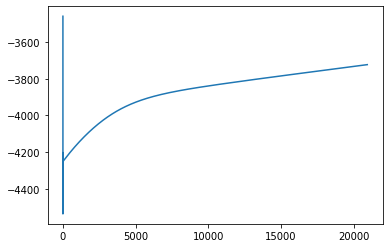

In [85]:
import matplotlib.pyplot as plt
likelihoods = likelihoods[likelihoods > -1000000]
x = np.arange(len(likelihoods))
plt.plot(x,likelihoods)

In [ ]:
And assess the preformance of our model

In [86]:
pHatFinal = LogitReg(X,betaFinal)
Yhat = 1*(pHatFinal >= 0.5)
accuracy = np.mean(Yhat == Y)
print(accuracy)

0.6276276276276276
